# Initializing

In [ ]:
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers
!pip install -U -q PyDrive
!pip install hazm
!pip install sentencepiece
!pip install emoji

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
assert torch.cuda.is_available()
import os
import zipfile
import pandas as pd
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, random_split
from transformers import BertTokenizer, XLMRobertaTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import numpy as np
import gc
import time
import datetime
import matplotlib.pyplot as plt
from hazm import word_tokenize
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import classification_report

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")
print(torch.__version__)

<IPython.core.display.Javascript object>

Found device: Tesla T4, n_gpu: 1
1.13.1+cu116


# Phase 1

## Pre-process

In [ ]:
import emoji
import re

not_punctuation = '[^ضصثقفغعهخحجچپشسیبلاتنمکگظطزرذدئوۀآةيژؤإأء]+'

def emoji2word(tw):
    return emoji.demojize(tw)

def remove_links(tw):
    return re.sub(r'^https?:\/\/.*[\r\n]*', 'http', tw, flags=re.MULTILINE)

def remove_eng(tw):
    return re.sub('[a-zA-Z]','',tw)

def keep_fa(tw):
  return re.sub(not_punctuation, " ", tw)

def text_cleaner(tw):
  try:
    data = remove_links(str(tw))
    data = emoji2word(data)
    data = keep_fa(data)
    return data
  except:
    print('errrrrr',tw)



<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/tweetAll20.xlsx')
# df = df.loc[df['judged'] == 1]
df = df.sample(frac=1).reset_index(drop=True)
df['label'] = df['label'].apply(lambda x: str(x).strip())
df['tweet'] = df['tweet'].apply(lambda x: str(x))
# df['tweet'] = df['tweet'].apply(lambda x: text_cleaner(x))
# df = df.head(2000)

<IPython.core.display.Javascript object>

In [ ]:
df['label'] = df['label'].apply(lambda x: 0 if x == '0- NO' else 1 if x == '1- Offensive' else 2)
df0 = df.loc[df['label'] == 0]#.sample(n = 3025)
df1 = df.loc[df['label'] == 1]#.sample(n = 3025)
df2 = df.loc[df['label'] == 2]
df = pd.concat([df0,df1,df2]).reset_index(drop=True)
df.groupby(['label'])['label'].count().reset_index(name='counts')

<IPython.core.display.Javascript object>

,label,counts
0,0,38630
1,1,16349
2,2,3025


In [ ]:
# df

<IPython.core.display.Javascript object>

In [ ]:
df['tweet_tkn'] = df['tweet'].apply(lambda x: word_tokenize(x))
df['tweet_tkn_len'] = df['tweet_tkn'].apply(lambda x: len(x))
df['status'] = 'train'

<IPython.core.display.Javascript object>

In [ ]:
numbers = df.loc[df['judged'] == 1].groupby(['label'])['label'].count().reset_index(name='counts')
for i, row in numbers.iterrows():
  ten_percent = row['counts'] // 100 * 1
  tmp = df[(df['label'] == row['label']) & (df['judged'] == 1)].sample(n = ten_percent)
  df.at[tmp.index, 'status'] = 'test'

<IPython.core.display.Javascript object>

In [ ]:
df.groupby(['status'])['status'].count().reset_index(name='counts')

<IPython.core.display.Javascript object>

,status,counts
0,test,379
1,train,57625


<IPython.core.display.Javascript object>

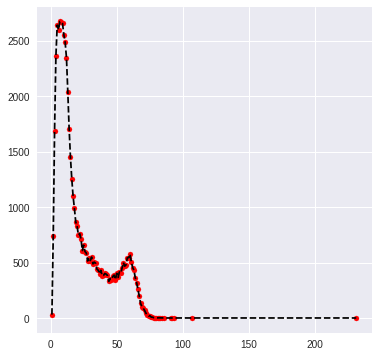

In [ ]:
df2 = df.groupby(['tweet_tkn_len'])['tweet_tkn_len'].count().reset_index(name='counts')

plt.style.use('seaborn')
plt.figure(figsize = (6, 6))
plt.plot(df2['tweet_tkn_len'], df2['counts'], color = 'black', linestyle = 'dashed')
  
plt.scatter(df2['tweet_tkn_len'], df2['counts'], marker = 'o', s = 25, color = 'red')
plt.show()

## pre-fine-tune

In [ ]:
def tokenize_and_format(sentences, model):
  if model in ['bert-base-multilingual-cased', 'HooshvareLab/bert-base-parsbert-uncased', 'arm-on/BERTweet-FA']:
    tokenizer = BertTokenizer.from_pretrained(model, do_lower_case=True)

  elif model == 'xlm-roberta-base':
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')


  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


<IPython.core.display.Javascript object>

## Code

### get_validation_performance

In [ ]:
# function to get validation accuracy
def get_validation_performance(val_set, model, batch_size, ret_output = False):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set)/batch_size) + 1

    total_correct = 0
    pred_labels = []

    for i in range(num_batches):

      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        pred_labels.extend(list(pred_flat))
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)

    if ret_output:
      return avg_val_accuracy, pred_labels
      
    return avg_val_accuracy



<IPython.core.display.Javascript object>

### model_training

In [ ]:
def model_training(model,optimizer, train_set,val_set,_val, batch_size, ju = 'all'):
  epochs = 10
  ju = 'Unjudged' if ju==0 else 'Judged' if ju==1 else ju
  for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} - {:} ========'.format(epoch_i + 1, epochs, ju))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    num_batches = int(len(train_set)/batch_size) + 1

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    val_acc, pred_labels = get_validation_performance(val_set, model, batch_size, ret_output=True)
    print(f"Validation accuracy: {val_acc}\n")
    print(classification_report(_val['label'], pred_labels, digits=4, zero_division=1, labels=[0,1,2]))
  
  return model, optimizer, total_train_loss

<IPython.core.display.Javascript object>

### main

In [ ]:
def main(_df):
  list_model = ['HooshvareLab/bert-base-parsbert-uncased']
  # list_model = ['bert-base-multilingual-cased', 'arm-on/BERTweet-FA', 'xlm-roberta-base','HooshvareLab/bert-base-parsbert-uncased']
  # list_model = ['arm-on/BERTweet-FA', 'xlm-roberta-base','HooshvareLab/bert-base-parsbert-uncased']

  # _df['label'] = _df['label'].apply(lambda x: 0 if x == '0- NO' else 1 if x == '1- Offensive' else 2)
  
  for _MODEL in list_model:

    
    batch_size = 64

    if _MODEL in ['bert-base-multilingual-cased', 'HooshvareLab/bert-base-parsbert-uncased', 'arm-on/BERTweet-FA']:
      model = BertForSequenceClassification.from_pretrained(
        _MODEL, # Use the 12-layer BERT model, with an uncased vocab. bert-base-uncased arm-on/BERTweet-FA
        # f'arm-on/BERTweet-FA', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.,        
    )
      
    elif _MODEL == 'xlm-roberta-base':
      model = RobertaForSequenceClassification.from_pretrained(
        _MODEL,
        num_labels = 3, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.,
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()

    optimizer = torch.optim.AdamW(model.parameters(),
                      lr = 2.5e-5, # args.learning_rate - default is 5e-5
                      # eps = 1e-15  # args.adam_epsilon  - default is 1e-8
                    )
    
    # for ju in [0, 1]:
    # for ju in [1]:
    # df = _df.loc[_df['judged'] == ju]
    df = _df
    df = df.sample(frac=1).reset_index(drop=True)
    texts = df.tweet.values
    labels = df.label.values

    ### tokenize_and_format() is a helper function provided in helpers.py ###
    input_ids, attention_masks = tokenize_and_format(texts, _MODEL)

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # print('Token IDs:', input_ids[0])


    total = len(df.loc[df['status'] == 'train'])

    num_train = int(total * .9)
    num_val = int(total * .1)
    # num_test = total - num_train - num_val
    num_test = len(df.loc[df['status'] == 'test'])

    _val = df.loc[(df['status'] == 'train')].sample(n = num_val)
    # _val = df.loc[(df['status'] == 'train') & (df['judged'] == 1)].sample(n = num_val)
    _test = df.loc[df['status'] == 'test']
    _train = df.drop(_val.index)
    _train = _train.drop(_test.index)

    # # make lists of 3-tuples (already shuffled the dataframe in cell above)

    train_set = [(input_ids[i], attention_masks[i], labels[i]) for i, row in _train.iterrows()]
    val_set = [(input_ids[i], attention_masks[i], labels[i]) for i, row in _val.iterrows()]
    test_set = [(input_ids[i], attention_masks[i], labels[i]) for i, row in _test.iterrows()]

    train_text = [texts[i] for i, row in _train.iterrows()]
    val_text = [texts[i] for i, row in _val.iterrows()]
    test_text = [texts[i] for i, row in _test.iterrows()]

    # print('train_set', len(train_set))
    # print('val_set',len(val_set))
    # print('test_set',len(test_set))
    # print('train_text',len(train_text))
    # print('val_text',len(val_text))
    # print('test_text',len(test_text))

    model,optimizer,total_train_loss = model_training(model, optimizer, train_set,val_set,_val, batch_size)
             

        

    val_acc, pred_labels = get_validation_performance(test_set, model, batch_size,ret_output=True)

    print("Test Set Report:\n")
    print(classification_report(_test['label'], pred_labels, digits=4, labels=[0,1,2]))
    print(f"Test Set accuracy: {val_acc}\n")

    cm = confusion_matrix(_test['label'], pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("\n")
    _test['pred'] = pred_labels
    df_test = _test[_test['label'] != _test['pred']].sample(n = 10)
    for i, row in df_test.iterrows():
      print(row['tweet'])
      print('Label: ',row['label'],'   Predict: ',row['pred'])
      print('====================================================')
    
    return model

  print("")
  print("Training complete! \n")
  print('====================================================\n')
  print('====================================================\n\n\n\n\n')

  del optimizer
  gc.collect()
  torch.cuda.empty_cache()


<IPython.core.display.Javascript object>

## Run

In [ ]:
gc.collect()
torch.cuda.empty_cache()
model = main(df)


In [ ]:
model.save_pretrained('/content/modelparsbert/')

<IPython.core.display.Javascript object>

# Bias Measurement

### tokenize_and_format

In [ ]:
def tokenize_and_format(sentences, model_dir):
  
  if model_dir == '//content//drive//MyDrive//Colab Notebooks//modelfarsi':
    tokenizer = BertTokenizer.from_pretrained('arm-on/BERTweet-FA', do_lower_case=True)

  if model_dir == '//content//drive//MyDrive//Colab Notebooks//modelparsbert':
    tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-uncased', do_lower_case=True)


  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

<IPython.core.display.Javascript object>

### get_validation_performance

In [ ]:
# function to get validation accuracy
def get_validation_performance(val_set, model, batch_size):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0

    num_batches = int(len(val_set)/batch_size) + 1

    total_correct = 0
    pred_labels = []

    for i in range(num_batches):

      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)

        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()

        pred_labels.extend(list(pred_flat))


      
    return pred_labels



<IPython.core.display.Javascript object>

### main

In [ ]:
def main(df, _MODEL):
  # list_model = ['//content//drive//MyDrive//Colab Notebooks//modelfarsi','//content//drive//MyDrive//Colab Notebooks//modelparsbert']
  # list_model = ['bert-base-multilingual-cased', 'arm-on/BERTweet-FA', 'xlm-roberta-base','HooshvareLab/bert-base-parsbert-uncased']
  # list_model = ['arm-on/BERTweet-FA', 'xlm-roberta-base','HooshvareLab/bert-base-parsbert-uncased']

  # _df['label'] = _df['label'].apply(lambda x: 0 if x == '0- NO' else 1 if x == '1- Offensive' else 2)
  
  # for _MODEL in list_model:
    
  batch_size = 64

  model = BertForSequenceClassification.from_pretrained(_MODEL)


  # Tell pytorch to run this model on the GPU.
  model.cuda()

  df = df.sample(frac=1).reset_index(drop=True)
  texts = df.tweet.values

  ### tokenize_and_format() is a helper function provided in helpers.py ###
  input_ids, attention_masks = tokenize_and_format(texts, _MODEL)

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  # print('Token IDs:', input_ids[0])


  total = len(df)
  
  _test = df

  test_set = [(input_ids[i], attention_masks[i]) for i, row in _test.iterrows()]

  test_text = [texts[i] for i, row in _test.iterrows()]

            

      

  pred_labels = get_validation_performance(test_set, model, batch_size)

  print("Test Set Report:\n")
  # print(classification_report(_test['label'], pred_labels, digits=4, labels=[0,1,2]))


  # cm = confusion_matrix(_test['label'], pred_labels)
  # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  # disp.plot()
  # plt.show()
  print("\n")
  _test['pred'] = pred_labels
  # df_test = _test[_test['label'] != _test['pred']].sample(n = 10)
  # for i, row in df_test.iterrows():
  #   print(row['tweet'])
  #   print('Label: ',row['label'],'   Predict: ',row['pred'])
  #   print('====================================================')

  gc.collect()
  torch.cuda.empty_cache()

  return _test




<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_excel('//content//drive//MyDrive//Colab Notebooks//Files//biasmeasurement//arab.xlsx')

df = df.sample(frac=1).reset_index(drop=True)
df['tweet'] = df['tweet'].apply(lambda x: str(x))


<IPython.core.display.Javascript object>

In [ ]:
list_model = ['//content//drive//MyDrive//Colab Notebooks//modelfarsi','//content//drive//MyDrive//Colab Notebooks//modelparsbert']
columns = ['arab','kord','lor','tork','balooch','zoroastrian','jewish','islam','christan']
outcome = {}
for c in columns:
  df = pd.read_excel(f'//content//drive//MyDrive//Colab Notebooks//Files//biasmeasurement//{c}.xlsx')
  for _model in list_model:
    df = df.sample(frac=1).reset_index(drop=True)
    df['tweet'] = df['tweet'].apply(lambda x: str(x))
    res = main(df, _model)
    print(_model)
    print(res.groupby([c,'pred'])['pred'].count().reset_index(name='counts'))
    print("\n =========== \n")
    outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')

Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   arab  pred  counts
0     0     0    4845
1     0     1     145
2     0     2      10
3     1     0    3500
4     1     1     585
5     1     2     915




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   arab  pred  counts
0     0     0    4811
1     0     1     187
2     0     2       2
3     1     0    3521
4     1     1     594
5     1     2     885




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   kord  pred  counts
0     0     0    4844
1     0     1     145
2     0     2      11
3     1     0    4560
4     1     1     326
5     1     2     114




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   kord  pred  counts
0     0     0    4810
1     0     1     187
2     0     2       3
3     1     0    4530
4     1     1     400
5     1     2      70




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   lor  pred  counts
0    0     0    4844
1    0     1     145
2    0     2      11
3    1     0    4395
4    1     1     504
5    1     2     101




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   lor  pred  counts
0    0     0    4810
1    0     1     187
2    0     2       3
3    1     0    4299
4    1     1     622
5    1     2      79




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   tork  pred  counts
0     0     0    4846
1     0     1     144
2     0     2      10
3     1     0    4455
4     1     1     418
5     1     2     127




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   tork  pred  counts
0     0     0    4812
1     0     1     185
2     0     2       3
3     1     0    4323
4     1     1     544
5     1     2     133




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   balooch  pred  counts
0        0     0    4844
1        0     1     145
2        0     2      11
3        1     0    4423
4        1     1     469
5        1     2     108




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   balooch  pred  counts
0        0     0    4810
1        0     1     187
2        0     2       3
3        1     0    4341
4        1     1     602
5        1     2      57




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   zoroastrian  pred  counts
0            0     0    4844
1            0     1     145
2            0     2      11
3            1     0    4562
4            1     1     332
5            1     2     106




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   zoroastrian  pred  counts
0            0     0    4810
1            0     1     187
2            0     2       3
3            1     0    4269
4            1     1     625
5            1     2     106




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   jewish  pred  counts
0       0     0    4844
1       0     1     145
2       0     2      11
3       1     0    4039
4       1     1     709
5       1     2     252




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   jewish  pred  counts
0       0     0    4810
1       0     1     187
2       0     2       3
3       1     0    3898
4       1     1     830
5       1     2     272




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   islam  pred  counts
0      0     0    4846
1      0     1     144
2      0     2      10
3      1     0    4490
4      1     1     303
5      1     2     207




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   islam  pred  counts
0      0     0    4813
1      0     1     185
2      0     2       2
3      1     0    4417
4      1     1     393
5      1     2     190




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelfarsi
   christan  pred  counts
0         0     0    4844
1         0     1     145
2         0     2      11
3         1     0    4406
4         1     1     513
5         1     2      81




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


Test Set Report:



//content//drive//MyDrive//Colab Notebooks//modelparsbert
   christan  pred  counts
0         0     0    4810
1         0     1     187
2         0     2       3
3         1     0    4202
4         1     1     735
5         1     2      63




<ipython-input-51-8aac8e64c904>:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  outcome[c] = res.groupby([c,'pred'])['pred'].count().reset_index(name='counts').to_dict('record')


In [ ]:
for i in outcome:
  count = 0
  for j in outcome[i]: 
    count += j['counts']
  print(count)

<IPython.core.display.Javascript object>

{'arab': [{'arab': 0, 'pred': 0, 'counts': 4811},
  {'arab': 0, 'pred': 1, 'counts': 187},
  {'arab': 0, 'pred': 2, 'counts': 2},
  {'arab': 1, 'pred': 0, 'counts': 3521},
  {'arab': 1, 'pred': 1, 'counts': 594},
  {'arab': 1, 'pred': 2, 'counts': 885}],
 'kord': [{'kord': 0, 'pred': 0, 'counts': 4810},
  {'kord': 0, 'pred': 1, 'counts': 187},
  {'kord': 0, 'pred': 2, 'counts': 3},
  {'kord': 1, 'pred': 0, 'counts': 4530},
  {'kord': 1, 'pred': 1, 'counts': 400},
  {'kord': 1, 'pred': 2, 'counts': 70}],
 'lor': [{'lor': 0, 'pred': 0, 'counts': 4810},
  {'lor': 0, 'pred': 1, 'counts': 187},
  {'lor': 0, 'pred': 2, 'counts': 3},
  {'lor': 1, 'pred': 0, 'counts': 4299},
  {'lor': 1, 'pred': 1, 'counts': 622},
  {'lor': 1, 'pred': 2, 'counts': 79}],
 'tork': [{'tork': 0, 'pred': 0, 'counts': 4812},
  {'tork': 0, 'pred': 1, 'counts': 185},
  {'tork': 0, 'pred': 2, 'counts': 3},
  {'tork': 1, 'pred': 0, 'counts': 4323},
  {'tork': 1, 'pred': 1, 'counts': 544},
  {'tork': 1, 'pred': 2, 'count

In [ ]:
res = {'arab': [
  {'arab': 0, 'pred': 1, 'counts': 145},
  {'arab': 0, 'pred': 2, 'counts': 10},
  {'arab': 1, 'pred': 1, 'counts': 585},
  {'arab': 1, 'pred': 2, 'counts': 915}],
 'kord': [{'kord': 0, 'pred': 1, 'counts': 145},
  {'kord': 0, 'pred': 2, 'counts': 11},
  {'kord': 1, 'pred': 1, 'counts': 326},
  {'kord': 1, 'pred': 2, 'counts': 114}],
 'lor': [ {'lor': 0, 'pred': 1, 'counts': 145},
  {'lor': 0, 'pred': 2, 'counts': 11},
  {'lor': 1, 'pred': 1, 'counts': 504},
  {'lor': 1, 'pred': 2, 'counts': 101}],
 'tork': [ {'tork': 0, 'pred': 1, 'counts': 144},
  {'tork': 0, 'pred': 2, 'counts': 10},
  {'tork': 1, 'pred': 1, 'counts': 418},
  {'tork': 1, 'pred': 2, 'counts': 127}],
 'balooch': [ {'balooch': 0, 'pred': 1, 'counts': 145},
  {'balooch': 0, 'pred': 2, 'counts': 11},
  {'balooch': 1, 'pred': 1, 'counts': 469},
  {'balooch': 1, 'pred': 2, 'counts': 108}],
 'zoroastrian': [{'zoroastrian': 0, 'pred': 1, 'counts': 145},
  {'zoroastrian': 0, 'pred': 2, 'counts': 11},
  {'zoroastrian': 1, 'pred': 1, 'counts': 332},
  {'zoroastrian': 1, 'pred': 2, 'counts': 106}],
 'jewish': [{'jewish': 0, 'pred': 1, 'counts': 145},
  {'jewish': 0, 'pred': 2, 'counts': 11},
  {'jewish': 1, 'pred': 1, 'counts': 709},
  {'jewish': 1, 'pred': 2, 'counts': 252}],
 'islam': [ {'islam': 0, 'pred': 1, 'counts': 144},
  {'islam': 0, 'pred': 2, 'counts': 10},
  {'islam': 1, 'pred': 1, 'counts': 303},
  {'islam': 1, 'pred': 2, 'counts': 207}],
 'christan': [  {'christan': 0, 'pred': 1, 'counts': 145},
  {'christan': 0, 'pred': 2, 'counts': 11},
  {'christan': 1, 'pred': 1, 'counts': 513},
  {'christan': 1, 'pred': 2, 'counts': 81}]}

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['sub', 'class', 'true', 'false'])
for i in res:
  _p0 = res[i][0]['counts'] / 5000
  _p2 = res[i][2]['counts'] / 5000
  df.at[len(df)] = [i, 1, _p2, _p0]

  _p1 = res[i][1]['counts'] / 5000
  _p3 = res[i][3]['counts'] / 5000
  df.at[len(df)] = [i, 2, _p3, _p1]

df['true/false'] = df['true'] / df['false']
df#.to_dict('record')

,sub,class,true,false,true/false
0,arab,1,0.117,0.029,4.034483
1,arab,2,0.183,0.002,91.5
2,kord,1,0.0652,0.029,2.248276
3,kord,2,0.0228,0.0022,10.363636
4,lor,1,0.1008,0.029,3.475862
5,lor,2,0.0202,0.0022,9.181818
6,tork,1,0.0836,0.0288,2.902778
7,tork,2,0.0254,0.002,12.7
8,balooch,1,0.0938,0.029,3.234483
9,balooch,2,0.0216,0.0022,9.818182
